# <center>Chest X-Ray Pneumonia Classification - Custom CNN + Transfer Learning</center>

<hr style="border: none; border-top: 1px solid #000;">

<center>
    <span>
        Created by <b>Ian Yap</b>
        &emsp;|&emsp;
        Data from <a href="https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images?resource=download"><b>Kaggle</b></a>
        &nbsp;
    </span>
</center>

<br>

<center>
    <span>
        <a href="https://www.linkedin.com/in/ian-yap-052870139/"><b>LinkedIn</b></a>
        &emsp;|&emsp;
        <a href="https://xiyap.github.io/"><b>Portfolio</b></a>
    </span>
</center>
    
<hr style="border: none; border-top: 1px solid #000;">


## Table of Contents

1. [Background](#Background)
2. [Objectives](#Objectives)
3. [Import Libraries](#Import_Libraries)
4. [Data Preparation](#Data_Preparation)
5. [Data Visualization](#Data_Visualization)
6. [Neural Network Model](#Neural_Network_Model)
    - [Model Evaluation](#Model_Evaluation)
    - [True Prediction Visualization](#True_Prediction_Visualization)
    - [False Prediction Visualization](#False_Prediction_Visualization)
    - [Class Activation Map](#Class_Activation_Map)
7. [Transfer Learning (InceptionResNetV2)](#Transfer_Learning_(InceptionResNetV2))
    - [Fine Tuning](#Fine_Tuning)
    - [Model Evaluation](#Model_Evaluation)
8. [Conclusion](#Conclusion)
9. [Exporting Model](#Exporting_Model)

## <a id='Background' href=#1> Background </a>

Pneumonia is a common and potentially serious lung infection that can be caused by various pathogens, including bacteria, viruses, and fungi. Chest X-rays are a commonly used diagnostic tool to detect and diagnose pneumonia. The interpretation of these X-rays is typically performed by radiologists, but the increasing workload and the need for timely diagnosis have inadvertently led to delays in the evaluation of results, subsequently impacting the prompt initiation of treatment. Therefore, an automated classification system could be crucial in alleviating the workload of radiologists while ensuring patients receive timely and effective medical care.

In this project, a dataset containing images of chest X-rays is used. These images are segregated into individual folders labeled as 'normal' and 'pneumonia'. Based on this dataset, an image classification model will be developed to assist healthcare personnels provide early diagnosis to determine if a patient has pneumonia based on their chest X-rays.

## <a id='Objectives' href=#1> Objectives </a>

The *main* objective of this project is to **develop an image classification model to detect signs of pneumonia from chest X-ray images.**

## <a id='Import_Libraries' href=#1> Import Libraries </a>

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import random
from tensorflow.random import set_seed

seed = 101
np.random.seed(seed)
random.seed(seed)
set_seed(seed)
tf.random.set_seed(seed)

## <a id='Data_Preparation' href=#1> Data Preparation </a>

Check if validation and test sets exist, create the directories and move the files:

In [3]:
import os
import shutil

def move_files(source_folder, destination_folder, move_percentage):
    # Get list of all files in source folder
    all_files = os.listdir(source_folder)
    
    # Randomly select N files
    N_files = int(len(all_files) * move_percentage)
    selected_files = random.sample(all_files, N_files)
    
    # Check if destination folder exists
    if not os.path.exists(destination_folder):
        print(f"Created destination folder: \n'{destination_folder}' \n")
        os.makedirs(destination_folder)
    else:
        # Check if destination folder empty
        if not os.listdir(destination_folder):
            print(f"Destination folder exists but empty. Moving files.\n")
        elif len(os.listdir(destination_folder)) < (0.1 * N_files):
            print(f"Destination folder exists with less files. Moving files.\n")
        else:
            print(f"Destination folder exists with files. Skipping.\n")
            return

    # Move the files to destination folder
    for file_name in selected_files:
        source_file_path = os.path.join(source_folder, file_name)
        destination_file_path = os.path.join(destination_folder, file_name)
        shutil.move(source_file_path, destination_file_path)

    print(f"Files moved from \n'{source_folder}' \nto \n'{destination_folder}'\n")

In [4]:
# Train path
train_dir = 'Chest_XRay_Data/Train'
train_normal_dir = os.path.join(train_dir, 'Normal')
train_pneumonia_dir = os.path.join(train_dir, 'Pneumonia')

# Validation path
val_dir = 'Chest_XRay_Data/Validation'
val_normal_dir = os.path.join(val_dir, 'Normal')
val_pneumonia_dir = os.path.join(val_dir, 'Pneumonia')

# Test path
test_dir = 'Chest_XRay_Data/Test'
test_normal_dir = os.path.join(test_dir, 'Normal')
test_pneumonia_dir = os.path.join(test_dir, 'Pneumonia')

In [5]:
val_percentage = 0.1

# Transfer
move_files(train_normal_dir, val_normal_dir, val_percentage)
move_files(train_pneumonia_dir, val_pneumonia_dir, val_percentage)

Created destination folder: 
'Chest_XRay_Data/Validation\Normal' 

Files moved from 
'Chest_XRay_Data/Train\Normal' 
to 
'Chest_XRay_Data/Validation\Normal'

Created destination folder: 
'Chest_XRay_Data/Validation\Pneumonia' 

Files moved from 
'Chest_XRay_Data/Train\Pneumonia' 
to 
'Chest_XRay_Data/Validation\Pneumonia'



In [6]:
print('Data Size:')
print(f'Trainining (Normal): {len(os.listdir(train_normal_dir))}')
print(f'Trainining (Pneumonia): {len(os.listdir(train_pneumonia_dir))}')
print(f'Validation (Normal): {len(os.listdir(val_normal_dir))}')
print(f'Validation (Pneumonia): {len(os.listdir(val_pneumonia_dir))}')
print(f'Test (Normal): {len(os.listdir(test_normal_dir))}')
print(f'Test (Pneumonia): {len(os.listdir(test_pneumonia_dir))}')

Data Size:
Trainining (Normal): 1094
Trainining (Pneumonia): 3146
Validation (Normal): 256
Validation (Pneumonia): 737
Test (Normal): 234
Test (Pneumonia): 390


## <a id='Data_Visualization' href=#1> Data Visualization </a>

Visualizing random samples of the dataset:

In [7]:
img_size = 230

Normal Chest X-Ray:
Original Image Size:
(1059, 1438, 3)
(2519, 2564, 3)
(974, 1442, 3)
(1128, 1360, 3)
(1541, 1654, 3)
(1634, 1956, 3)
(1040, 1380, 3)
(1047, 1306, 3)


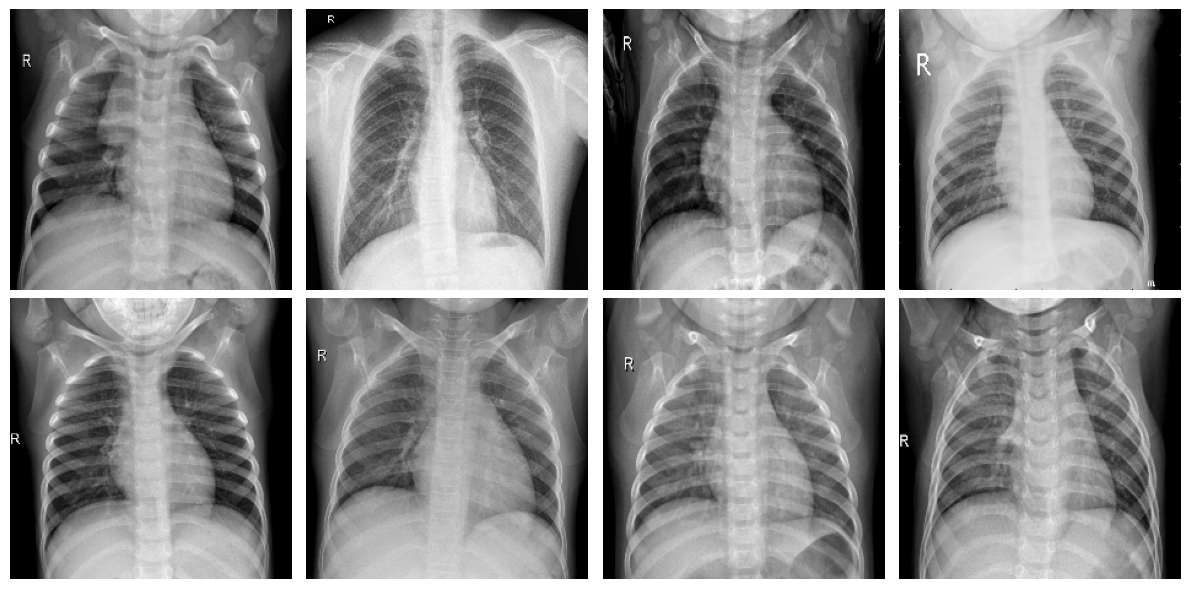

In [8]:
print('Normal Chest X-Ray:')
print('Original Image Size:')

plt.figure(figsize = (12, 6))

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    random_image_file = random.choice(os.listdir(train_normal_dir))
    random_image_path = os.path.join(train_normal_dir, random_image_file)
    img = cv2.imread(random_image_path)
    print(img.shape)
    img = cv2.resize(img, (img_size, img_size))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

Pneumonia Chest X-Ray:
Original Image Size:
(816, 960, 3)
(1072, 1296, 3)
(800, 1176, 3)
(1044, 1368, 3)
(740, 1118, 3)
(250, 450, 3)
(1096, 1232, 3)
(584, 1008, 3)


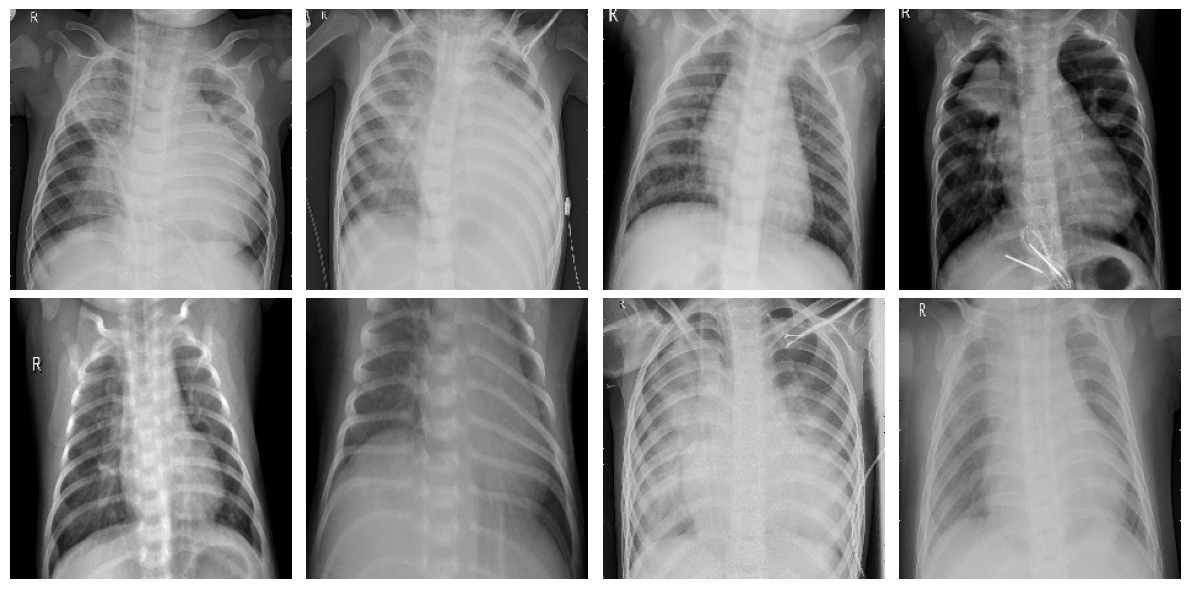

In [9]:
print('Pneumonia Chest X-Ray:')
print('Original Image Size:')

plt.figure(figsize = (12, 6))

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    random_image_file = random.choice(os.listdir(train_pneumonia_dir))
    random_image_path = os.path.join(train_pneumonia_dir, random_image_file)
    img = cv2.imread(random_image_path)
    print(img.shape)
    img = cv2.resize(img, (img_size, img_size))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

## <a id='Neural_Network_Model' href=#1> Neural Network Model </a>

Develop the neural network model:

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1.0 / 255,
                                  rotation_range = 20,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  zoom_range = 0.1,
                                  fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (img_size, img_size),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    shuffle = True,
                                                    seed = seed
                                                   )

val_datagen = ImageDataGenerator(rescale = 1.0 / 255)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size = (img_size, img_size),
                                                batch_size = batch_size,
                                                class_mode = 'binary',
                                                seed = seed
                                               )

class_mapping = train_generator.class_indices
print(class_mapping)

Found 4240 images belonging to 2 classes.
Found 993 images belonging to 2 classes.
{'Normal': 0, 'Pneumonia': 1}


In [11]:
# Model 1 (custom CNN)
model = tf.keras.models.Sequential([
    # Convo Layer 1
    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Convo Layer 2
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Convo Layer 3
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Convo Layer 4
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Convo Layer 5
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Dense Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# model.summary()

In [12]:
from tensorflow.keras.optimizers import Adam

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['binary_accuracy', 'AUC'])

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_binary_accuracy',
                                            patience = 3,
                                            verbose = 0,
                                            factor = 0.5,
                                            min_lr = 0.00001)

In [14]:
train_data = len(os.listdir(train_normal_dir)) + len(os.listdir(train_pneumonia_dir))
val_data = len(os.listdir(val_normal_dir)) + len(os.listdir(val_pneumonia_dir))
steps_per_epoch = train_data // batch_size
validation_steps = val_data // batch_size

history = model.fit(
    train_generator,
    batch_size = batch_size,
    epochs = 20,
    steps_per_epoch = steps_per_epoch,
    verbose = 1,
    validation_data = val_generator,
    validation_steps = validation_steps,
    callbacks = [learning_rate_reduction]
)

Epoch 1/20
132/132 [==============================] - 79s 569ms/step - loss: 0.4718 - binary_accuracy: 0.7961 - auc: 0.7628 - val_loss: 0.3186 - val_binary_accuracy: 0.8609 - val_auc: 0.9516 - lr: 0.0010
Epoch 2/20
132/132 [==============================] - 75s 569ms/step - loss: 0.2544 - binary_accuracy: 0.8952 - auc: 0.9482 - val_loss: 0.1655 - val_binary_accuracy: 0.9385 - val_auc: 0.9804 - lr: 0.0010
Epoch 3/20
132/132 [==============================] - 75s 566ms/step - loss: 0.2349 - binary_accuracy: 0.9054 - auc: 0.9554 - val_loss: 0.1913 - val_binary_accuracy: 0.9254 - val_auc: 0.9861 - lr: 0.0010
Epoch 4/20
132/132 [==============================] - 73s 551ms/step - loss: 0.1902 - binary_accuracy: 0.9313 - auc: 0.9696 - val_loss: 0.1673 - val_binary_accuracy: 0.9365 - val_auc: 0.9882 - lr: 0.0010
Epoch 5/20
132/132 [==============================] - 73s 549ms/step - loss: 0.1791 - binary_accuracy: 0.9242 - auc: 0.9743 - val_loss: 0.1568 - val_binary_accuracy: 0.9425 - val_auc: 

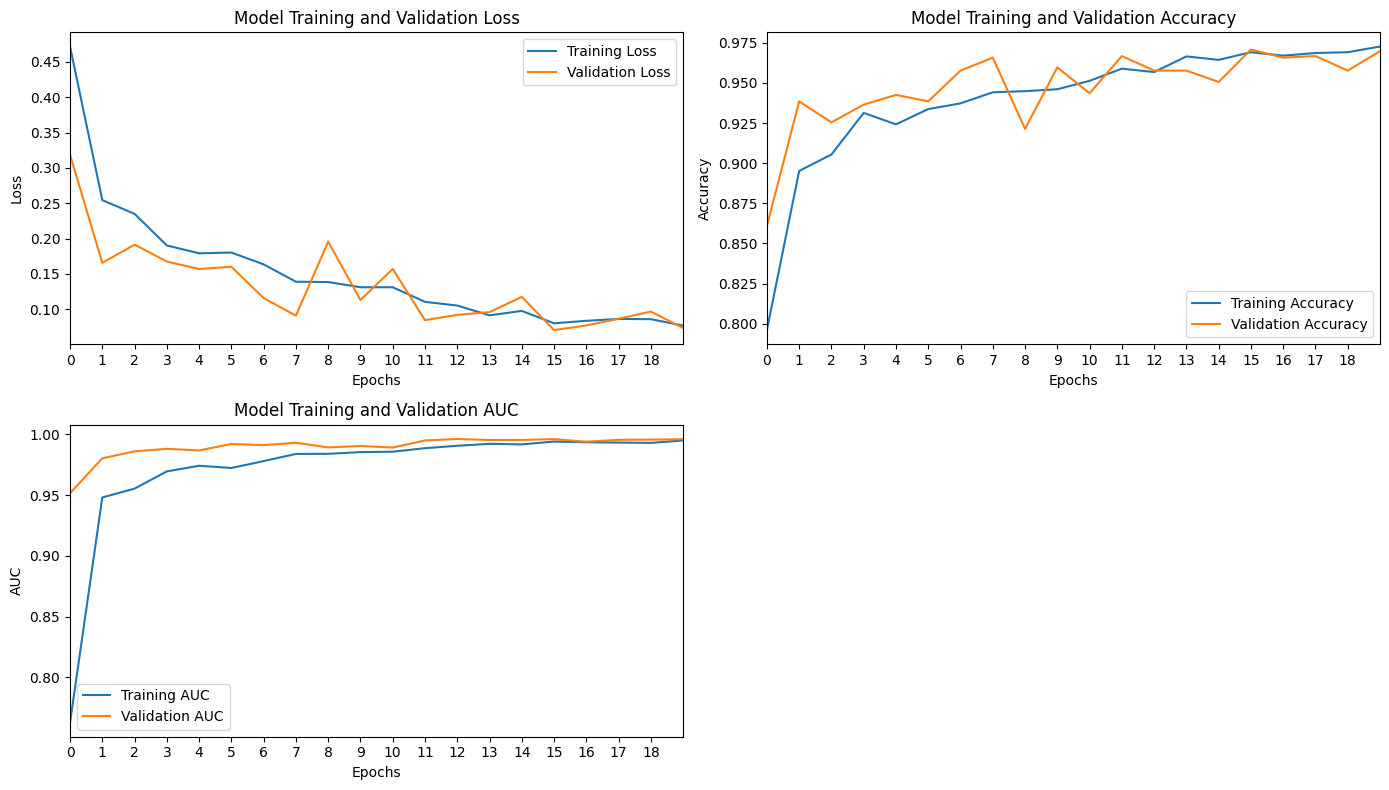

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

titles = ['Loss', 'Accuracy', 'AUC']
metrics = ['loss', 'binary_accuracy', 'auc']
labels = ['Training', 'Validation']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i // 2, i % 2]
    ax.plot(history.history[metric], label = f'{labels[0]} {title}')
    ax.plot(history.history[f'val_{metric}'], label = f'{labels[1]} {title}')
    ax.set_title(f'Model Training and Validation {title}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(title)
    ax.set_xlim(0, 19)
    ax.set_xticks(np.arange(0, 19, step = 1))
    ax.legend()

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

In [16]:
min_val_loss = min(history.history['val_loss'])
max_val_binary_accuracy = max(history.history['val_binary_accuracy'])
max_val_auc = max(history.history['val_auc'])
print(f'Min loss on validation set: {min_val_loss:.3f}')
print(f'Max binary accuracy on validation set: {max_val_binary_accuracy * 100:.3f} %')
print(f'Max AUC on validation set: {max_val_auc * 100:.3f} %')

Min loss on validation set: 0.070
Max binary accuracy on validation set: 97.077 %
Max AUC on validation set: 99.628 %


### <a id='Model_Evaluation' href=#1> Model Evaluation </a>

Evaluate the trained model using the test set:

In [17]:
# Custom function to print classification report and confusion matrix
def model_report(model, prediction):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
    
    print(classification_report(y_test, prediction, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
    cm = confusion_matrix(y_test, prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()

In [18]:
from random import sample

test_size = len(os.listdir(test_normal_dir)) + len(os.listdir(test_pneumonia_dir))

test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (img_size, img_size),
                                                  batch_size = test_size,
                                                  class_mode = 'binary',
                                                  seed = seed
                                                 )

X_test, y_test = test_generator.next()

class_mapping = test_generator.class_indices
print(class_mapping)

Found 624 images belonging to 2 classes.
{'Normal': 0, 'Pneumonia': 1}


In [19]:
evaluation_result = model.evaluate(X_test, y_test)
print(f'Model loss on test set: {evaluation_result[0]:.3f}')
print(f'Model binary accuracy on test set: {(evaluation_result[1] * 100):.2f} %')
print(f'Model AUC on test set: {(evaluation_result[2] * 100):.2f} %')

20/20 [==============================] - 0s 16ms/step - loss: 0.2629 - binary_accuracy: 0.8958 - auc: 0.9849
Model loss on test set: 0.263
Model binary accuracy on test set: 89.58 %
Model AUC on test set: 98.49 %


20/20 [==============================] - 0s 14ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.98      0.74      0.84       234
Pneumonia (Class 1)       0.86      0.99      0.92       390

           accuracy                           0.90       624
          macro avg       0.92      0.86      0.88       624
       weighted avg       0.91      0.90      0.89       624



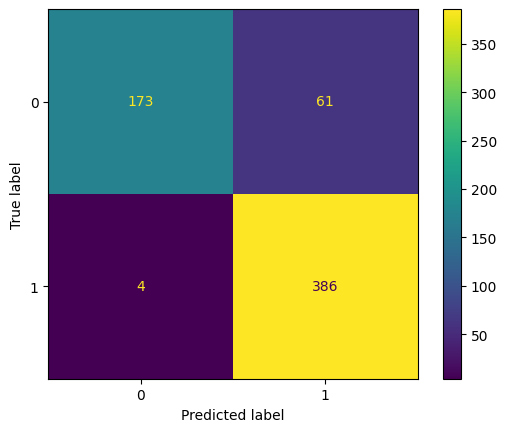

In [20]:
threshold = 0.5

yhat_test = model.predict(X_test)
yhat_test = yhat_test.reshape(1, -1)[0]
binary_yhat_test = (yhat_test > threshold).astype(int)

model_report(y_test, binary_yhat_test)

### <a id='True_Prediction_Visualization' href=#1> True Prediction Visualization </a>

Visualize the images that have true predictions:

Test Result: 
{'Normal': 0, 'Pneumonia': 1}


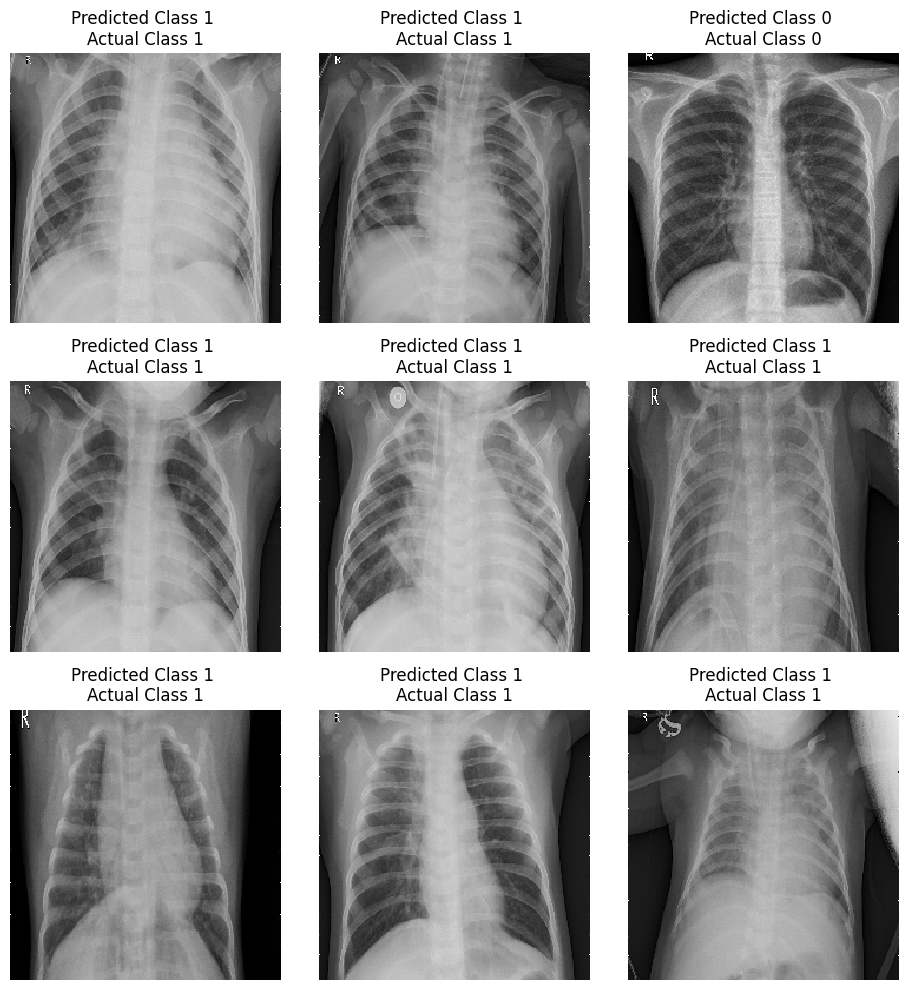

In [21]:
true_prediction = np.nonzero(binary_yhat_test == y_test)[0]

i = 0
N_image_shown = 9
plt.figure(figsize = (10, 10))

print(f'Test Result: \n{class_mapping}')

for c in true_prediction[:N_image_shown]:
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[c], cmap = 'gray', interpolation = 'none')
    plt.title(f'Predicted Class {binary_yhat_test[c]} \nActual Class {int(y_test[c])}')
    plt.axis('off')
    plt.tight_layout()
    i += 1

### <a id='False_Prediction_Visualization' href=#1> False Prediction Visualization </a>

Visualize the images that have false predictions:

Test Result: 
{'Normal': 0, 'Pneumonia': 1}


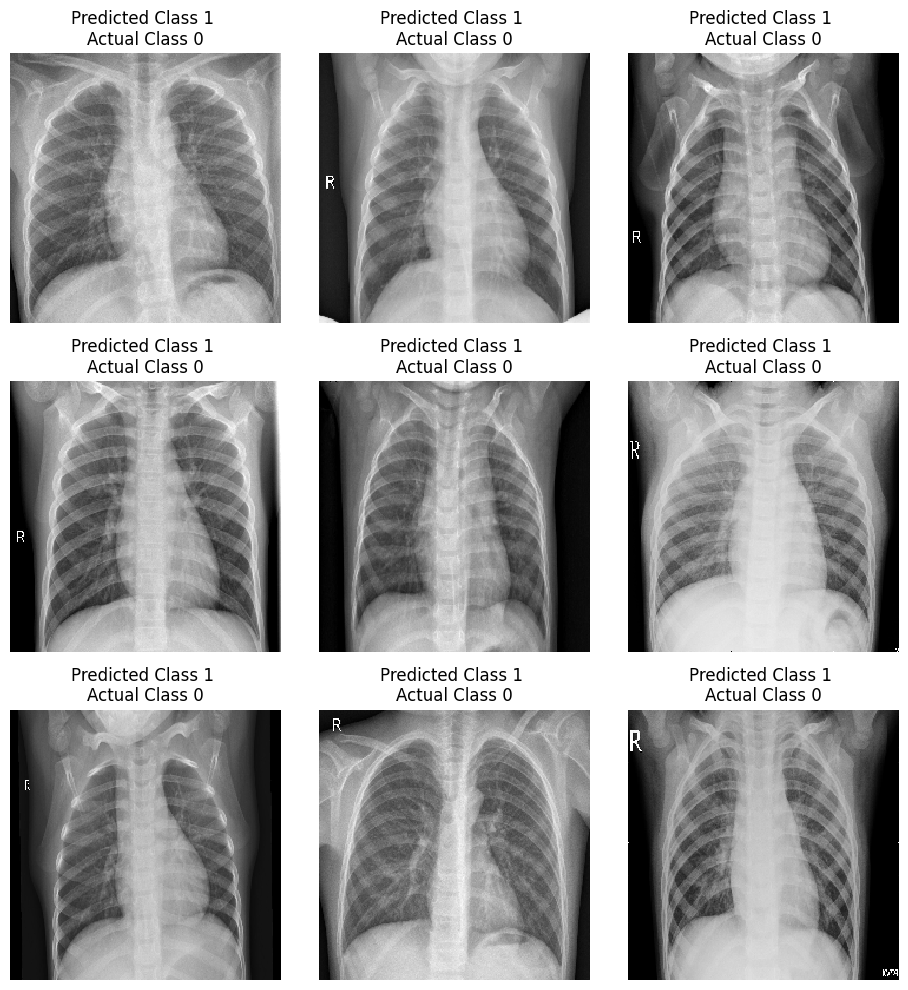

In [22]:
false_prediction = np.nonzero(binary_yhat_test != y_test)[0]

i = 0
N_image_shown = 9
plt.figure(figsize = (10, 10))

print(f'Test Result: \n{class_mapping}')

for c in false_prediction[:N_image_shown]:
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[c], cmap = 'gray', interpolation = 'none')
    plt.title(f'Predicted Class {binary_yhat_test[c]} \nActual Class {int(y_test[c])}')
    plt.axis('off')
    plt.tight_layout()
    i += 1

### <a id='Class_Activation_Map' href=#1> Class Activation Map </a>

Plot class activation map to gain insight on the region of the chest X-rays that contribute most to the classification result:

In [25]:
files = os.listdir(val_pneumonia_dir)
random_file_name = random.choice(files)
random_file_path = os.path.join(val_pneumonia_dir, random_file_name)

1/1 [==============================] - 0s 102ms/step


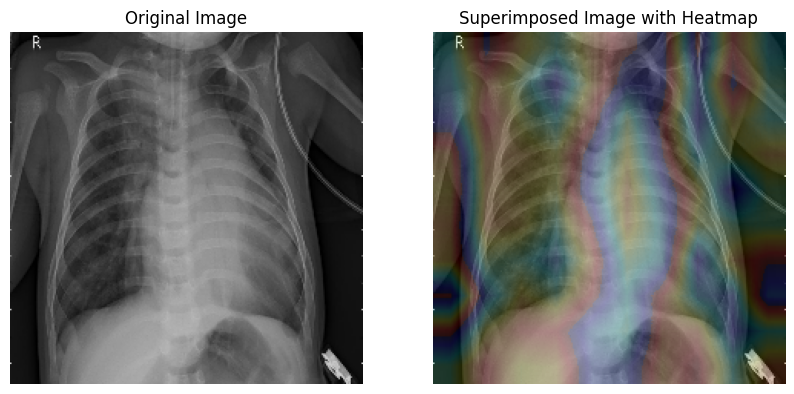

In [26]:
from tensorflow.keras.preprocessing import image

last_conv_layer = model.get_layer('conv2d_4')
cam_model = tf.keras.Model(inputs = model.input, outputs = [last_conv_layer.output, model.output])

img_path = random_file_path  # File path
img = image.load_img(img_path, target_size = (230, 230))
img_array = image.img_to_array(img)
img_array /= 255.0
img_array = np.expand_dims(img_array, axis=0)

last_conv_layer_output, model_output = cam_model.predict(img_array)
last_conv_layer_output_tf = tf.convert_to_tensor(last_conv_layer_output)
model_output_tf = tf.convert_to_tensor(model_output)
img_array = tf.convert_to_tensor(img_array)

with tf.GradientTape() as tape:
    tape.watch(img_array)
    predictions = cam_model(img_array)
    target_class_output = predictions[1][:, 0]

gradients = tape.gradient(target_class_output, img_array)
grads_val = tf.reduce_mean(gradients)
weights = np.mean(grads_val)

cam = np.dot(last_conv_layer_output[0], weights)
cam = cv2.resize(cam, (img.width, img.height))
cam = np.maximum(cam, 0)
cam = cam / np.max(cam)
cam = np.uint8(255 * cam)
cam = np.sum(cam, axis=-1, keepdims=True)
cam = np.uint8(cam)

heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
resized_original = cv2.resize(cv2.imread(img_path), (img.width, img.height))
alpha = 0.15  # Heatmap transparency
beta = 1 - alpha # Ori image transparency

superimposed_img = cv2.addWeighted(resized_original, beta, heatmap, alpha, 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].imshow(resized_original)
axes[0].axis('off')
axes[0].set_title('Original Image')

axes[1].imshow(superimposed_img)
axes[1].axis('off')
axes[1].set_title('Superimposed Image with Heatmap')

plt.show()

## <a id='Transfer_Learning_(InceptionResNetV2)' href=#1> Transfer Learning (InceptionResNetV2) </a>

Perform transfer learning on InceptionResNetV2 to utilize the trained model:

In [27]:
tf.keras.backend.clear_session()

In [28]:
from keras.applications import inception_resnet_v2

pre_trained_model = inception_resnet_v2.InceptionResNetV2(
    input_shape = (img_size, img_size, 3),
    include_top = False,
    weights = 'imagenet')

pre_trained_model.trainable = False

# pre_trained_model.summary()

In [29]:
pre_trained_model_output = pre_trained_model.get_layer('conv_7b_ac').output

x = tf.keras.layers.GlobalAveragePooling2D()(pre_trained_model_output)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
model_2_output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model_2 = tf.keras.Model(inputs = pre_trained_model.input, outputs = model_2_output)
# model_2.summary()

In [30]:
train_datagen_2 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    preprocessing_function = inception_resnet_v2.preprocess_input
)

train_generator_2 = train_datagen_2.flow_from_directory(train_dir,
                                                        target_size = (img_size, img_size),
                                                        batch_size = batch_size,
                                                        class_mode = 'binary',
                                                        shuffle = True,
                                                        seed = seed
                                                       )

val_datagen_2 = ImageDataGenerator(
    preprocessing_function = inception_resnet_v2.preprocess_input
)

val_generator_2 = val_datagen_2.flow_from_directory(val_dir,
                                                    target_size = (img_size, img_size),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    seed = seed
                                                   )

class_mapping = train_generator_2.class_indices
print(class_mapping)

Found 4240 images belonging to 2 classes.
Found 993 images belonging to 2 classes.
{'Normal': 0, 'Pneumonia': 1}


In [31]:
model_2.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['binary_accuracy', 'AUC']
)

In [32]:
model_2_history = model_2.fit(
    train_generator_2,
    batch_size = batch_size,
    epochs = 20,
    steps_per_epoch = steps_per_epoch,
    verbose = 0,
    validation_data = val_generator_2,
    validation_steps = validation_steps,
    callbacks = [learning_rate_reduction]
)

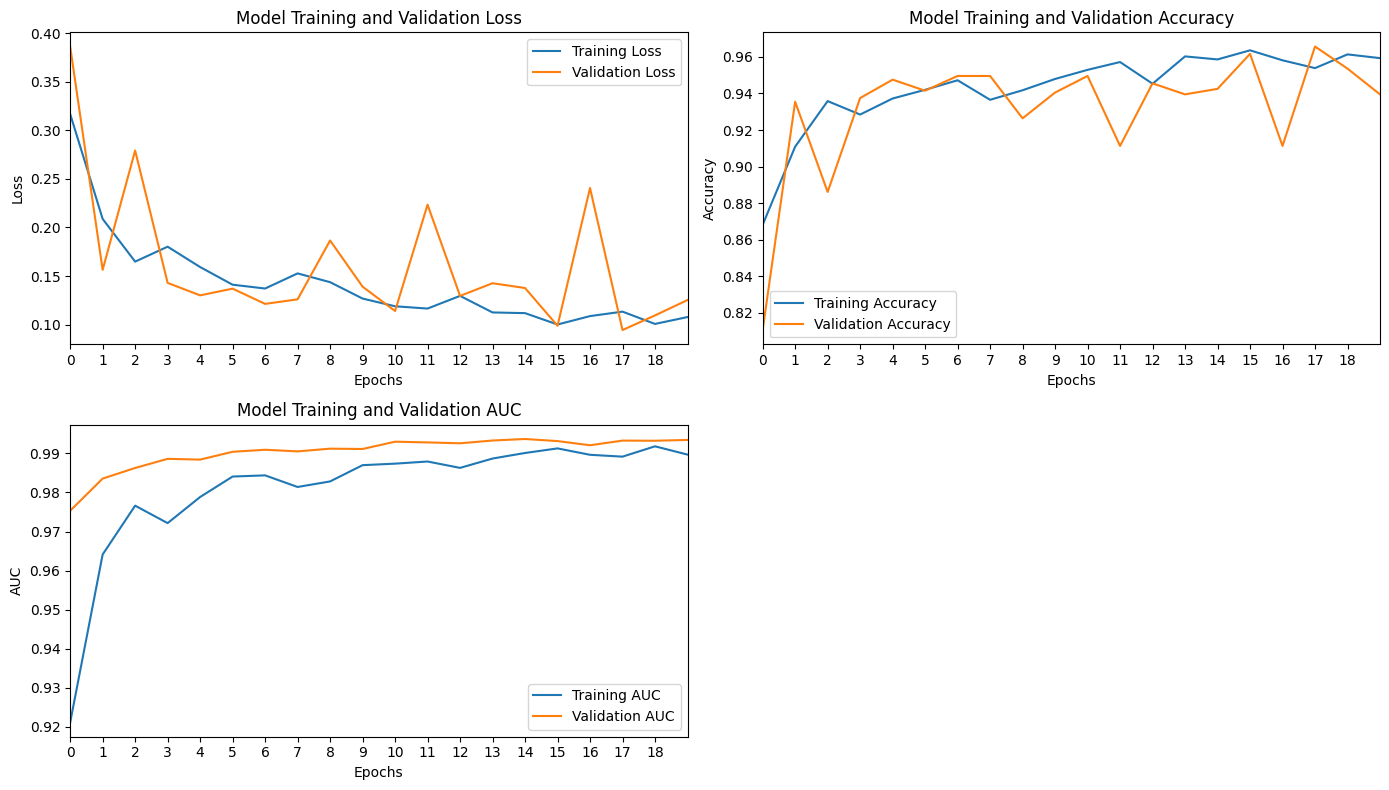

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

titles = ['Loss', 'Accuracy', 'AUC']
metrics = ['loss', 'binary_accuracy', 'auc']
labels = ['Training', 'Validation']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i // 2, i % 2]
    ax.plot(model_2_history.history[metric], label = f'{labels[0]} {title}')
    ax.plot(model_2_history.history[f'val_{metric}'], label = f'{labels[1]} {title}')
    ax.set_title(f'Model Training and Validation {title}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(title)
    ax.set_xlim(0, 19)
    ax.set_xticks(np.arange(0, 19, step = 1))
    ax.legend()

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

In [34]:
min_val_loss = min(model_2_history.history['val_loss'])
max_val_binary_accuracy = max(model_2_history.history['val_binary_accuracy'])
max_val_auc = max(model_2_history.history['val_auc'])
print(f'Min loss on validation set: {min_val_loss:.3f}')
print(f'Max binary accuracy on validation set: {max_val_binary_accuracy * 100:.3f} %')
print(f'Max AUC on validation set: {max_val_auc * 100:.3f} %')

Min loss on validation set: 0.094
Max binary accuracy on validation set: 96.573 %
Max AUC on validation set: 99.368 %


### <a id='Fine_Tuning' href=#1> Fine Tuning </a>

Fine tune the transfer learning model by training the last few layers with our data:

In [35]:
for layer in pre_trained_model.layers[-12:]:
    layer.trainable = True

# pre_trained_model.summary()

In [36]:
model_2.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['binary_accuracy', 'AUC']
)

In [37]:
model_2_2_history = model_2.fit(
    train_generator_2,
    batch_size = batch_size,
    epochs = 20,
    steps_per_epoch = steps_per_epoch,
    verbose = 0,
    validation_data = val_generator_2,
    validation_steps = validation_steps,
    callbacks = [learning_rate_reduction]
)

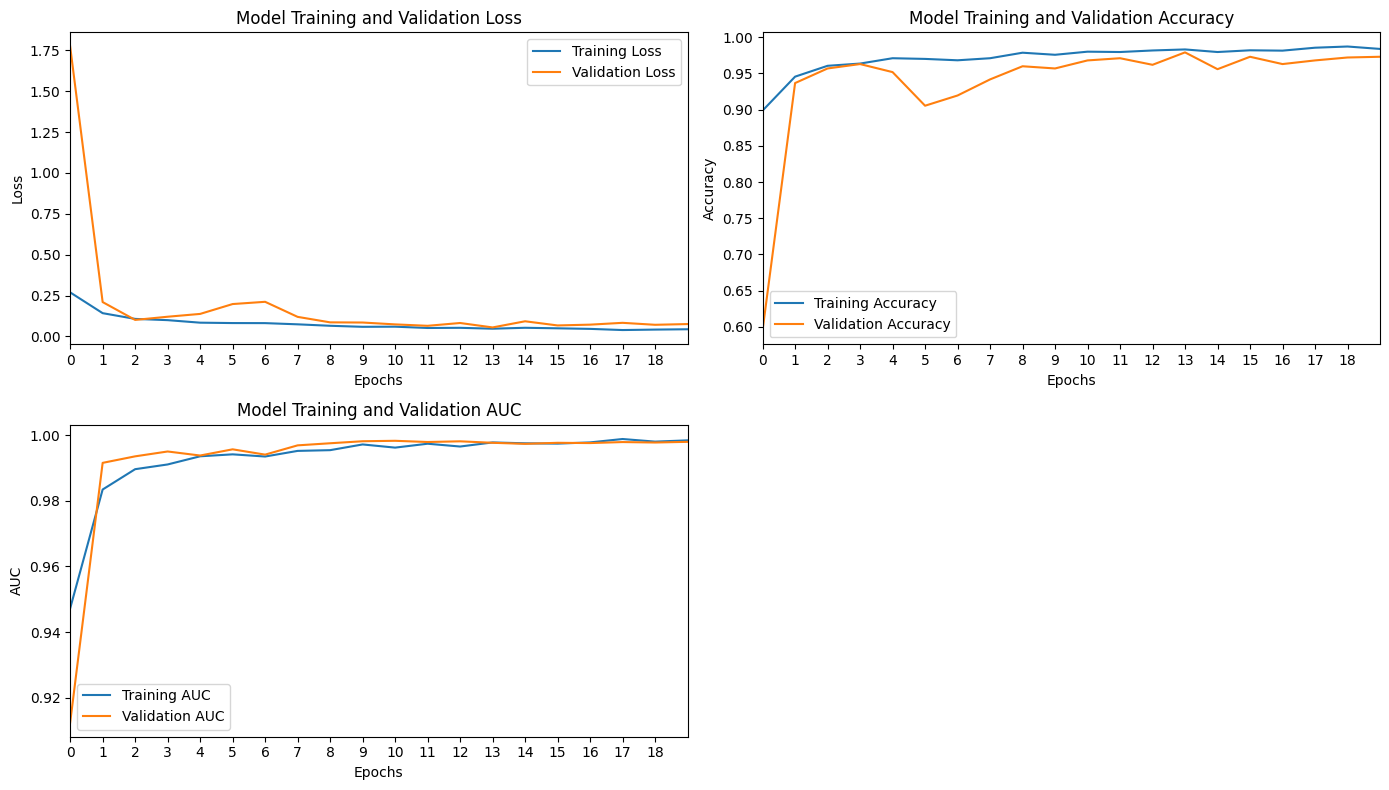

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

titles = ['Loss', 'Accuracy', 'AUC']
metrics = ['loss', 'binary_accuracy', 'auc']
labels = ['Training', 'Validation']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i // 2, i % 2]
    ax.plot(model_2_2_history.history[metric], label = f'{labels[0]} {title}')
    ax.plot(model_2_2_history.history[f'val_{metric}'], label = f'{labels[1]} {title}')
    ax.set_title(f'Model Training and Validation {title}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(title)
    ax.set_xlim(0, 19)
    ax.set_xticks(np.arange(0, 19, step = 1))
    ax.legend()

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

In [39]:
min_val_loss = min(model_2_2_history.history['val_loss'])
max_val_binary_accuracy = max(model_2_2_history.history['val_binary_accuracy'])
max_val_auc = max(model_2_2_history.history['val_auc'])
print(f'Min loss on validation set: {min_val_loss:.3f}')
print(f'Max binary accuracy on validation set: {max_val_binary_accuracy * 100:.3f} %')
print(f'Max AUC on validation set: {max_val_auc * 100:.3f} %')

Min loss on validation set: 0.055
Max binary accuracy on validation set: 97.883 %
Max AUC on validation set: 99.824 %


### <a id='Model_Evaluation' href=#1> Model Evaluation </a>

Evaluate the fine tuned InceptionResNetV2 model using the test set:

In [40]:
test_datagen_2 = ImageDataGenerator(
    preprocessing_function = inception_resnet_v2.preprocess_input
)

test_generator_2 = test_datagen_2.flow_from_directory(test_dir,
                                                      target_size = (img_size, img_size),
                                                      batch_size = test_size,
                                                      class_mode = 'binary',
                                                      seed = seed
                                                     )

X_test_2, y_test_2 = test_generator_2.next()

class_mapping = test_generator_2.class_indices
print(class_mapping)

Found 624 images belonging to 2 classes.
{'Normal': 0, 'Pneumonia': 1}


In [41]:
evaluation_result_2 = model_2.evaluate(X_test_2, y_test_2)
print(f'Model loss on test set: {evaluation_result_2[0]:.3f}')
print(f'Model binary accuracy on test set: {(evaluation_result_2[1] * 100):.2f} %')
print(f'Model AUC on test set: {(evaluation_result_2[2] * 100):.2f} %')

20/20 [==============================] - 3s 141ms/step - loss: 0.1625 - binary_accuracy: 0.9391 - auc: 0.9926
Model loss on test set: 0.163
Model binary accuracy on test set: 93.91 %
Model AUC on test set: 99.26 %


In [42]:
threshold = 0.5

yhat_test_2 = model_2.predict(X_test_2)
yhat_test_2 = yhat_test_2.reshape(1, -1)[0]
binary_yhat_test_2 = (yhat_test_2 > threshold).astype(int)

20/20 [==============================] - 7s 150ms/step


                     precision    recall  f1-score   support

   Normal (Class 0)       0.98      0.85      0.91       234
Pneumonia (Class 1)       0.92      0.99      0.95       390

           accuracy                           0.94       624
          macro avg       0.95      0.92      0.93       624
       weighted avg       0.94      0.94      0.94       624



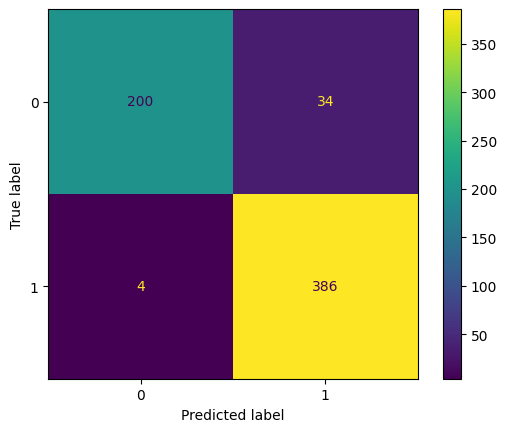

In [43]:
model_report(y_test_2, binary_yhat_test_2)

## <a id='Conclusion' href=#1> Conclusion </a>

By comparing the custom CNN model (model 1) to the fine tuned transfer learning model (model 2), **model 2 has a lower loss (0.163), higher accuracy (93.91%) and higher AUC (99.26%) on the test set.** This means that model 2 is effective at distinguishing between the classes.

For this classification model, it is crucial to **minimize the false negatives to ensure that individuals with pneumonia do not get misdiagnosed**. Hence, the model is designed to have **high recall in class 1 (99%)**, emphasizing in capturing all potential cases to prevent oversights in patient diagnosis.

Meanwhile, **less emphasis is placed on precision** as cases flagged as positive will undergo subsequent screening to validate the true positive status. This will greatly reduce the workload of radiologists as patients with negative pneumonia diagnosis can be filtered out rapidly. Nevertheless, model 2 has a **higher precision on class 1 (92%)** compared to model 1.

To conclude, a **model leveraging transfer learning with further fine tuning using our custom data could produce a more accurate image classification model** as the pretrained model has very deep layers and has been trained using a vast dataset, making it proficient in identifying intricate features within an image. This strategic approach not only enhances precision but also accelerates the model development process, offering significant time savings in data gathering and model training.

## <a id='Exporting_Model' href=#1> Exporting Model </a>

Export the best model for future use:

In [44]:
model_2.save('pneumonia_detection_model.h5')

In [45]:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('pneumonia_detection_model.h5')